### Analyze Logistic Regression Coefficients

- Joel Stremmel
- 12-26-23

##### About

Fit Logistic Regression on the formatted data over many bootstrap iterations and analyze the average coefficient values with 95% confidence intervals.

##### Imports

In [1]:
import os
import pickle
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

##### Set Parameters

In [2]:
add_summaries = False
outcome = "Alliance" # "cohesion" # "Alliance"
ngram_range = (2, 4)
min_df = 5
max_df = 0.9
seed = 42
max_iter = 10000
penalty = None
solver = "saga"
num_bootstrap = 1000
input_dir = "./data"
output_file = f"./results/{outcome}_lr_coef.png"

##### Load Formatted Data

In [3]:
if add_summaries:
    sums = 'Xwsum'
else:
    sums = 'X'
    
with open(os.path.join(input_dir, f"{outcome}_{sums}_folds.pkl"), "rb") as f:
    X_folds = pickle.load(f)

with open(os.path.join(input_dir, f"{outcome}_y_folds.pkl"), "rb") as f:
    y_folds = pickle.load(f)

##### Check Data Shape

In [4]:
assert len(X_folds) == len(y_folds), "Expected the same number of folds in X and y."
X = list(X_folds.values())
y = list(y_folds.values())

##### Check Number of Samples

In [5]:
num_samples = len([x for xx in y for x in xx])
print(f"Total number of samples: {num_samples}.")

Total number of samples: 108.


##### Check Target Prevalence

In [6]:
print(f"Target prevalance: {np.mean(np.concatenate(y))}.")

Target prevalance: 0.5925925925925926.


##### Fit a Model to All of the Data

In [7]:
X_train, y_train = np.concatenate(X, axis=0), np.concatenate(y, axis=0)
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train, y_train = X_train[indices], y_train[indices]

tfidf_vectorizer = CountVectorizer(
    strip_accents="unicode",
    analyzer="word",
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english",
    ngram_range=ngram_range,
    min_df=min_df,
    max_df=max_df,
    lowercase=True,
)

train_features = tfidf_vectorizer.fit_transform(X_train)

clfs = []
for i in range(num_bootstrap):
    boot_indices = np.arange(len(y_train))
    boot_sample_indices = np.random.choice(
        boot_indices, size=len(boot_indices), replace=True
    )
    boot_train_features = train_features[boot_sample_indices]
    boot_y_train = y_train[boot_sample_indices]

    lr = LogisticRegression(
        solver=solver,
        fit_intercept=True,
        max_iter=max_iter,
        penalty=penalty,
        class_weight=None,
        random_state=seed,
    )
    lr = lr.fit(boot_train_features, boot_y_train)
    clfs.append(lr)

##### Define a Function to Plot the LR Model Coefficients

In [8]:
def plot_coefs(clfs, features, top_n=10, x_size=12, y_size=12):
    """
    Plot top N coefficients by absolute value in descending order
    """

    all_coefs = []
    for clf in clfs:
        features_and_intercept = np.concatenate((features, ["intercept"]), axis=0)
        coefficients = np.concatenate((clf.coef_[0], clf.intercept_), axis=0)
        all_coefs.append(coefficients)

    coef_matrix = np.vstack(all_coefs)
    mean_coefficients = np.mean(coef_matrix, axis=0)
    std_coefficients = np.std(coef_matrix, axis=0)

    indices = (-np.abs(mean_coefficients)).argsort()
    top_coefs_mean = mean_coefficients[indices][0:top_n].tolist()
    top_coefs_std = std_coefficients[indices][0:top_n].tolist()
    top_feats = features_and_intercept[indices][0:top_n].tolist()

    top_coefs_mean.reverse()
    top_coefs_std.reverse()
    top_feats.reverse()

    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title("Logistic Regression Coefficients")
    plt.barh(
        range(len(top_coefs_mean)),
        top_coefs_mean,
        xerr=1.96 * np.array(top_coefs_std),
        color="navy",
        align="center",
    )
    plt.yticks(range(len(top_coefs_mean)), top_feats)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.axvline(x=0, color="red", linestyle="--")
    plt.savefig(output_file)

    plt.show()

##### Plot Coefficients

<Figure size 640x480 with 0 Axes>

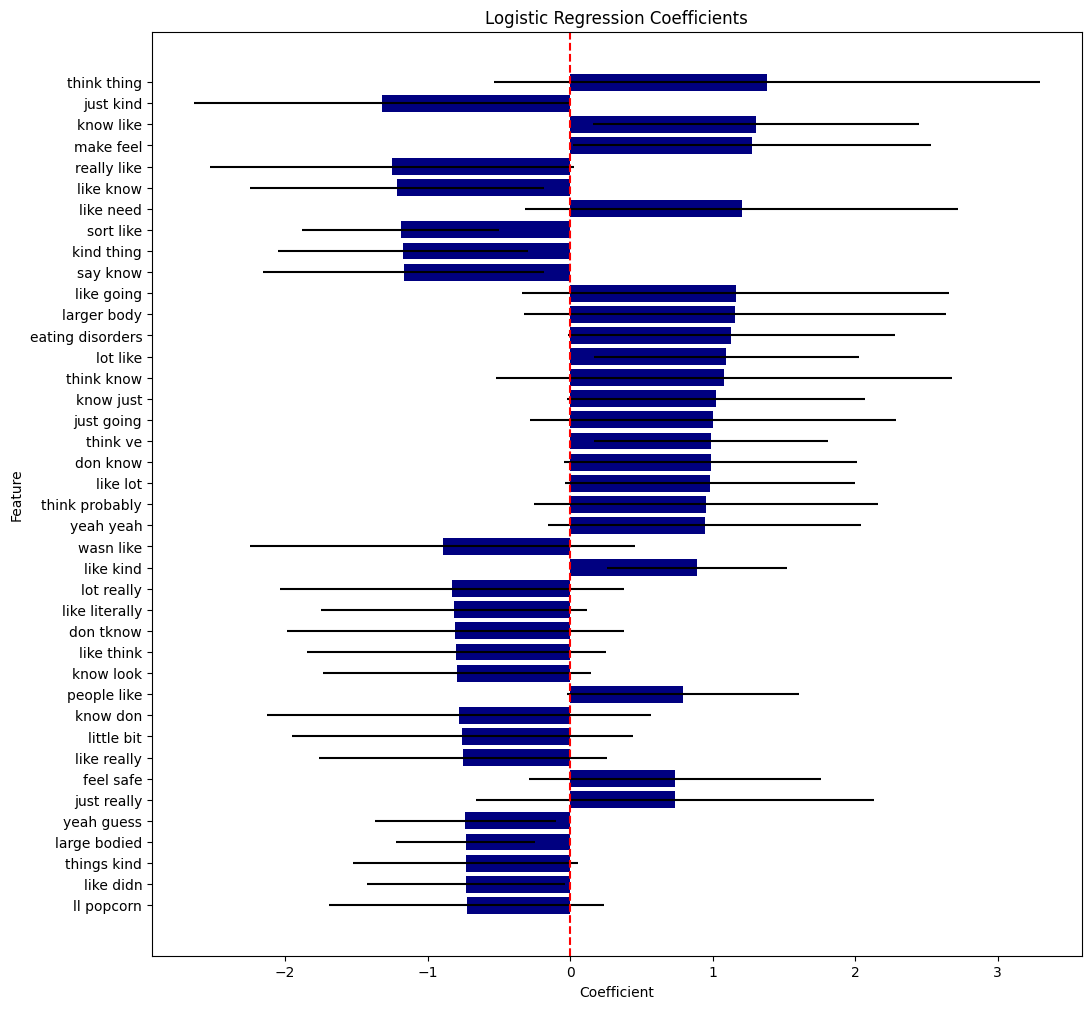

In [9]:
plot_coefs(
    clfs, tfidf_vectorizer.get_feature_names_out(), top_n=40, x_size=12, y_size=12
)